# Vendor Performance Analysis

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sqlite3
import scipy.stats as stats
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')
%matplotlib inline

In [69]:
# Connecting the database 

conn = sqlite3.connect('inventory1.db')

# Fetching all the data present in the final summary table

df = pd.read_sql_query('SELECT * FROM final_summary_table', conn)
df.head()
df.to_csv('final_summary_table.csv')

# Exploratory Data Analysis

* Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.

* In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis.

---

In [3]:
# Summary Stats

df.describe().T

count          mean            std        min  \
VendorNumber           10692.0  1.065065e+04   18753.519148       2.00   
Brand                  10692.0  1.803923e+04   12662.187074      58.00   
ActualPrice            10692.0  3.564367e+01     148.246016       0.49   
PurchasePrice          10692.0  2.438530e+01     109.269375       0.36   
Volume                 10692.0  8.473605e+02     664.309212      50.00   
TotalPurchaseQuantity  10692.0  3.140887e+03   11095.086769       1.00   
TotalPurchaseDollars   10692.0  3.010669e+04  123067.799627       0.71   
TotalSalesPrice        10692.0  1.416338e+04   34628.961255       0.00   
TotalSalesQuantity     10692.0  2.294216e+03    8284.090410       0.00   
TotalSalesDollars      10692.0  3.126745e+04  124394.410611       0.00   
TotalExciseTax         10692.0  1.337203e+03    8297.277213       0.00   
FreightCost            10692.0  6.143376e+04   60938.458032       0.09   
GrossProfit            10692.0  1.160760e+03   15326.719211 -453358.65   
ProfitMargin           10692.0          -inf            NaN       -inf   
StockTurnover          10692.0  1.412150e+00       5.596056       0.00   
SalesToPurchaseRatio   10692.0  2.070744e+00       7.824576       0.00   

                                25%           50%           75%           max  
VendorNumber            3951.000000   7153.000000   9552.000000  2.013590e+05  
Brand                   5793.500000  18761.500000  25514.250000  9.063100e+04  
ActualPrice               10.990000     15.990000     28.990000  7.499990e+03  
PurchasePrice              6.840000     10.455000     19.482500  5.681810e+03  
Volume                   750.000000    750.000000    750.000000  2.000000e+04  
TotalPurchaseQuantity     36.000000    262.000000   1975.750000  3.376600e+05  
TotalPurchaseDollars     453.457500   3655.465000  20738.245000  3.811252e+06  
TotalSalesPrice          143.840000   1919.875000  11723.442500  5.320467e+05  
TotalSalesQuantity        21.000000    169.000000   1384.000000  2.588150e+05  
TotalSalesDollars        429.370000   3663.975000  20932.192500  3.774623e+06  
TotalExciseTax             2.920000     31.555000    299.060000  2.665613e+05  
FreightCost            14069.870000  50293.620000  79528.990000  2.570321e+05  
GrossProfit             -388.385000    143.355000   2232.997500  3.474117e+05  
ProfitMargin             -38.751016      7.768129     28.908560  9.971384e+01  
StockTurnover              0.500000      0.732809      0.935840  2.718000e+02  
SalesToPurchaseRatio       0.720715      1.084224      1.406639  3.494571e+02

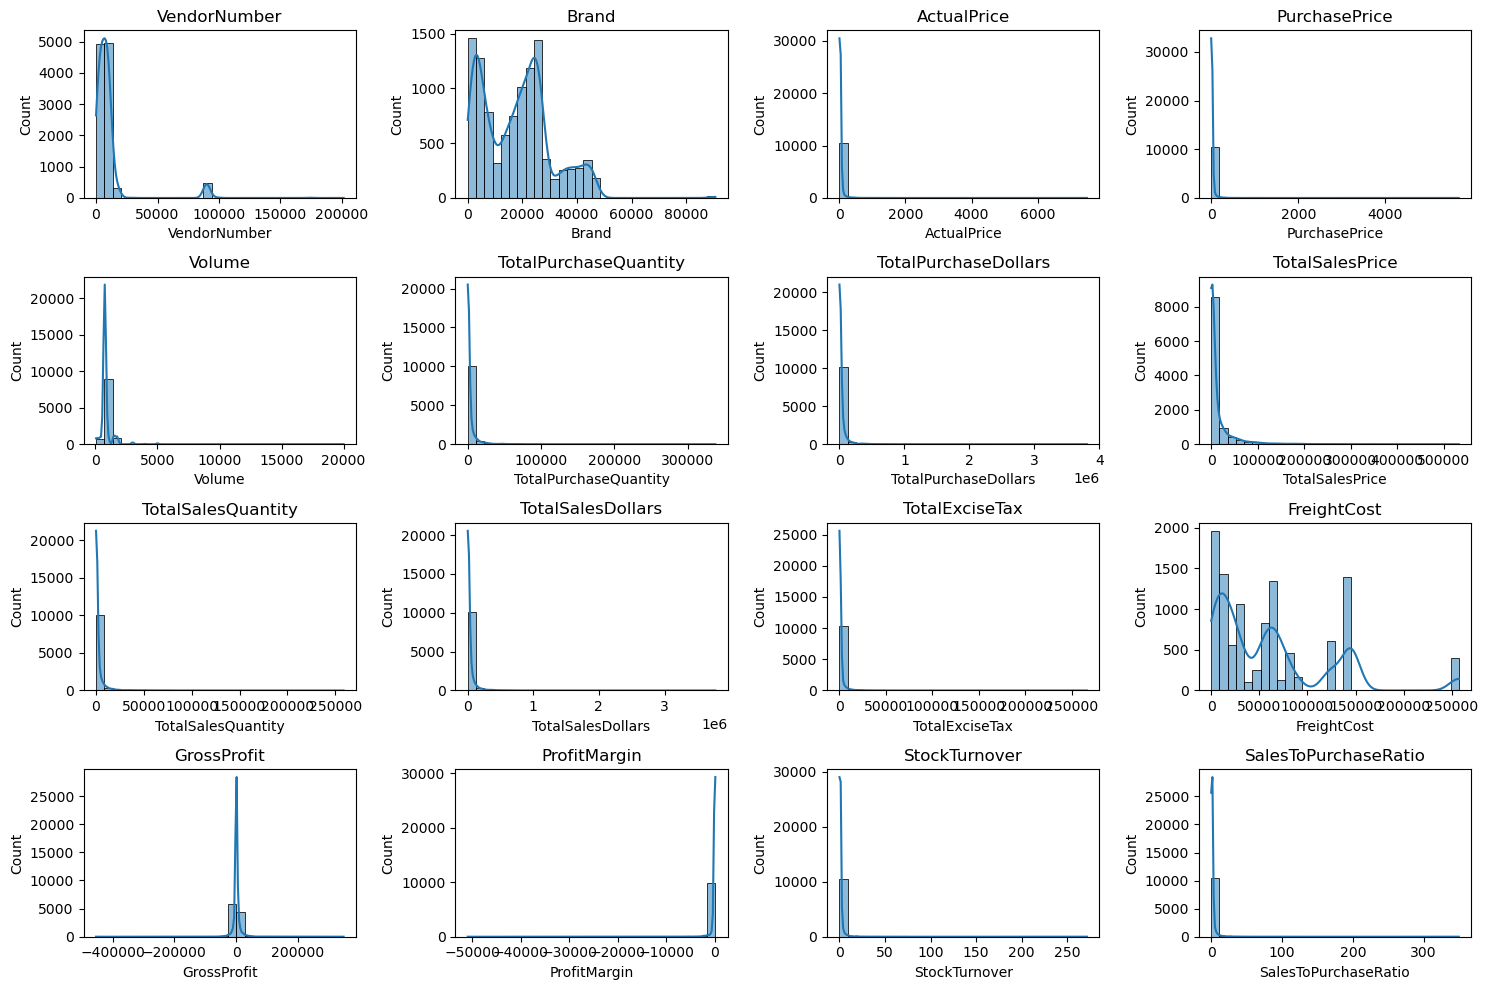

In [4]:
# let's start by creating numerical cols and then using histogram we see their distribution 

numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

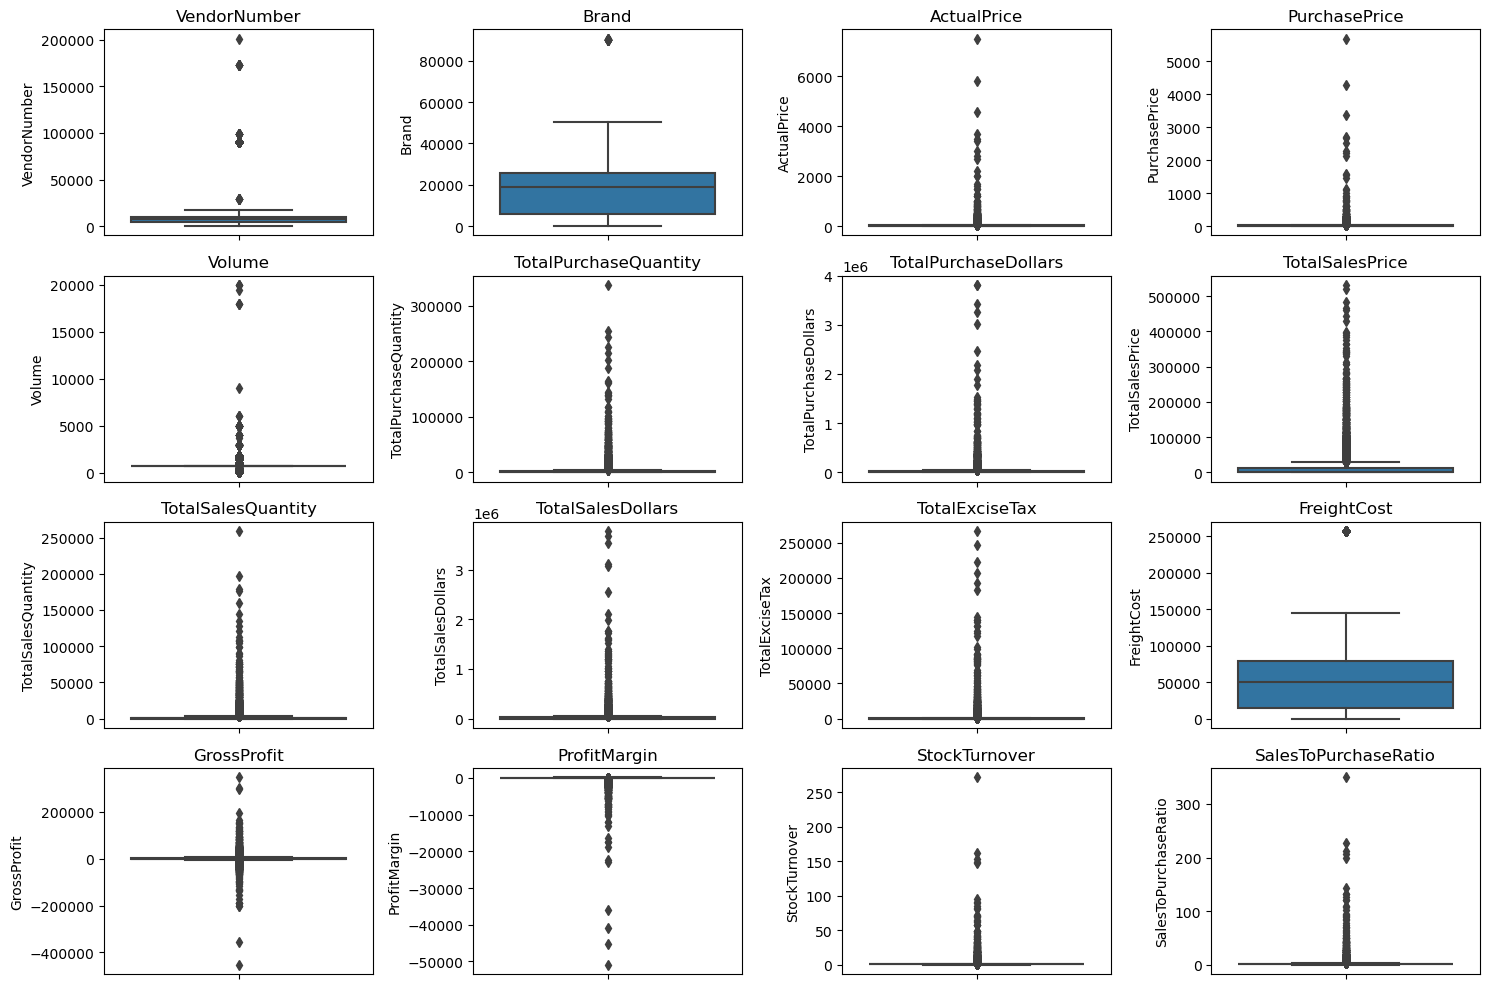

In [5]:
# We can observe Outliers much better using boxplot

plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.boxplot(y = df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

## Summary Statistics Insights:
### Negative & Zero Values:

- **Gross Profit**: Minimum value is -453,358.65, indicating significant losses. Some products or transactions may be selling at a loss due to high costs or being discounted below the purchase price.

- **Profit Margin**: Has a minimum of -∞, which suggests cases where revenue is zero or even lower than costs.

- **Total Sales Quantity & Sales Dollars**: Minimum values are 0, meaning some products were purchased but never sold. These could be slow-moving or   obsolete stock.

### Outliers Indicated by High Standard Deviations:
- **Purchase & Actual Prices**: The max values (5,681.81 & 7,499.99) are significantly higher than the mean (24.39 & 35.64), indicating potential premium products.

- **Freight Cost**: Huge variation, from 0.09 to 257,032.07, suggests logistics inefficiencies or bulk shipments.

- **Stock Turnover**: Ranges from 0 to 274.5, implying some products sell extremely fast while others remain in stock indefinitely. Value more than 1 indicates that sold quantity for that product is higher than purchased quantity due to either sales being fulfilled from older stock.


In [6]:
df.shape

(10692, 18)

In [7]:
# let's filter out the data by removing the incosistencies

df = pd.read_sql_query(''' 
        SELECT * 
        FROM final_summary_table
        WHERE GrossProfit > 0
            AND ProfitMargin > 0
            AND SalesToPurchaseRatio > 0
''', conn)


In [8]:
df.shape

(6285, 18)

In [9]:
df.head(10)

VendorNumber                  VendorName  Brand  \
0         17035           PERNOD RICARD USA   8068   
1          3960    DIAGEO NORTH AMERICA INC   3545   
2           480             BACARDI USA INC   3858   
3          3960    DIAGEO NORTH AMERICA INC   3489   
4           480             BACARDI USA INC   2663   
5         10000         MAJESTIC FINE WINES   6570   
6          9165  ULTRA BEVERAGE COMPANY LLP   3650   
7          3960    DIAGEO NORTH AMERICA INC   4260   
8           480             BACARDI USA INC   3348   
9           480             BACARDI USA INC   3857   

                    Description  ActualPrice  PurchasePrice  Volume  \
0              Absolut 80 Proof        24.99          18.24  1750.0   
1               Ketel One Vodka        29.99          21.89  1750.0   
2              Grey Goose Vodka        23.99          17.77   750.0   
3                     Tanqueray        27.99          20.73  1750.0   
4            Dewars White Label        29.99          21.42  1750.0   
5  Kendall Jackson Chard Vt RSV        10.99           6.77   750.0   
6         Patron Silver Tequila        48.99          33.81   750.0   
7   Capt Morgan Original Barrel        21.99          16.66  1750.0   
8           Bombay Sapphire Gin        29.99          22.38  1750.0   
9              Grey Goose Vodka        49.99          38.27  1750.0   

   TotalPurchaseQuantity  TotalPurchaseDollars  TotalSalesPrice  \
0                 187407            3418303.68        365628.68   
1                 138109            3023206.01        428454.74   
2                 138809            2466635.93        352917.21   
3                  91835            1903739.55        399771.60   
4                  69001            1478001.42        390902.86   
5                 215668            1460072.36        150210.75   
6                  42951            1452173.31        519515.18   
7                  79078            1317439.48        120171.16   
8                  57349            1283470.62        363229.69   
9                  33388            1277758.76        460915.39   

   TotalSalesQuantity  TotalSalesDollars  TotalExciseTax  FreightCost  \
0            145074.0         3535864.76       266561.29    123780.22   
1             99417.0         3117155.83       182667.44    257032.07   
2            106580.0         2548893.20        83919.92     89286.27   
3             71399.0         2099802.01       131184.43    257032.07   
4             50325.0         1595656.75        92464.93     89286.27   
5            159418.0         1759397.98        17920.67     17587.59   
6             32830.0         1577833.70        25847.45     68054.70   
7             78290.0         1619199.60       143853.17    257032.07   
8             44829.0         1399260.71        82368.02     89286.27   
9             24610.0         1282474.90        45219.28     89286.27   

   GrossProfit  ProfitMargin  StockTurnover  SalesToPurchaseRatio  
0    117561.08      3.324818       0.774112              1.034392  
1     93949.82      3.013960       0.719844              1.031076  
2     82257.27      3.227176       0.767818              1.033348  
3    196062.46      9.337188       0.777470              1.102988  
4    117655.33      7.373474       0.729337              1.079604  
5    299325.62     17.012957       0.739182              1.205007  
6    125660.39      7.964109       0.764359              1.086533  
7    301760.12     18.636376       0.990035              1.229050  
8    115790.09      8.275090       0.781688              1.090216  
9      4716.14      0.367737       0.737091              1.003691

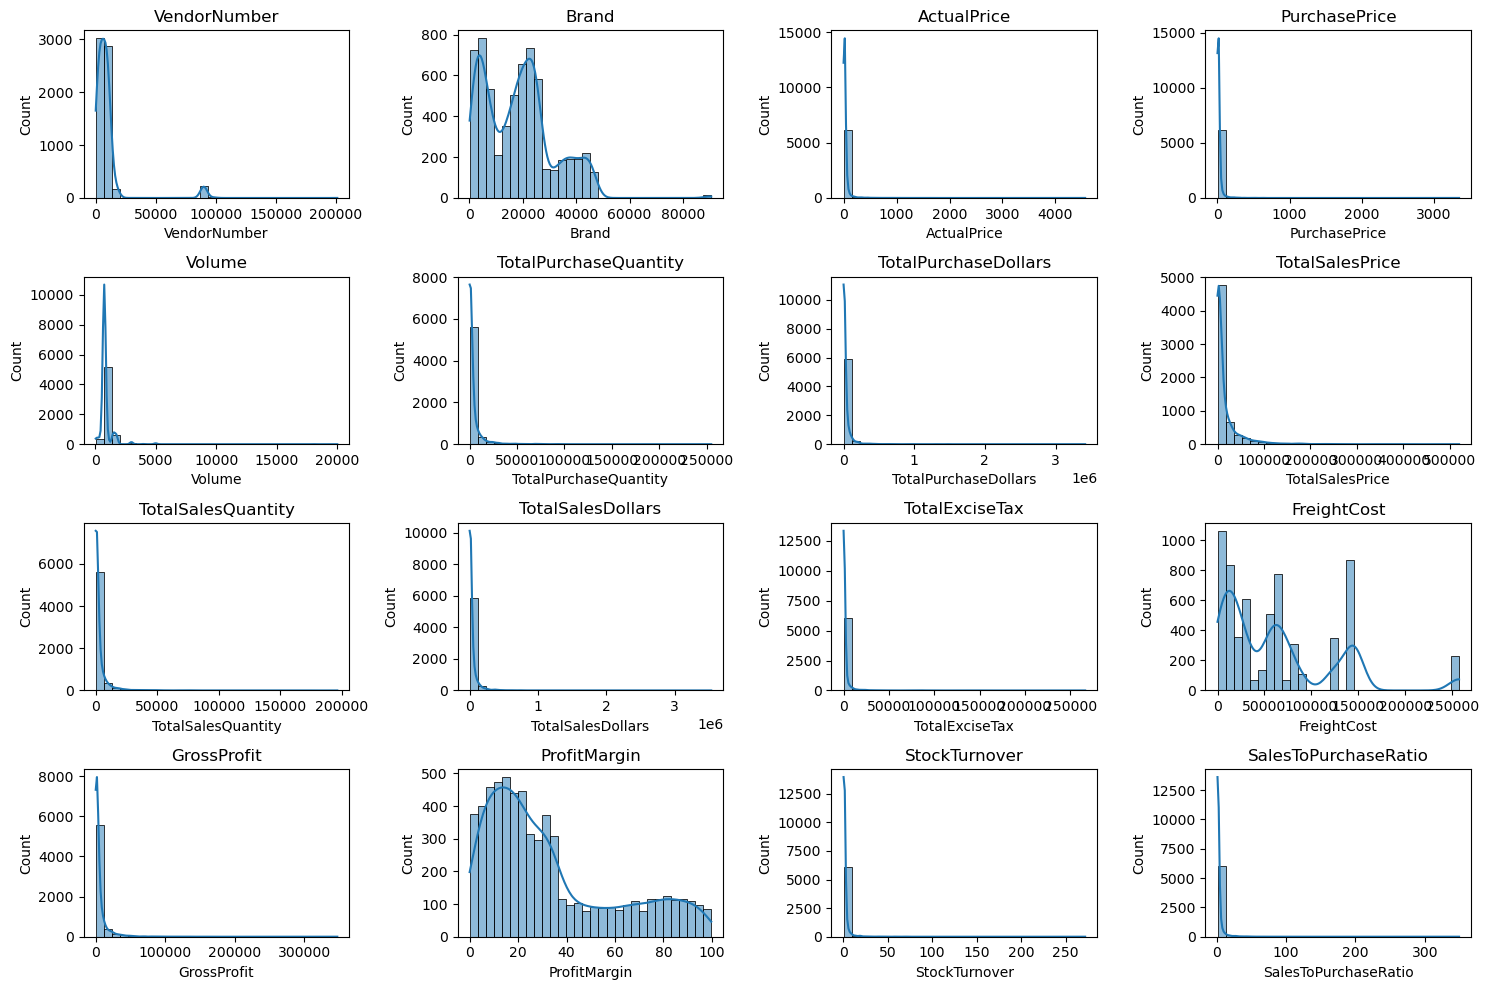

In [10]:
numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col],kde=True,bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

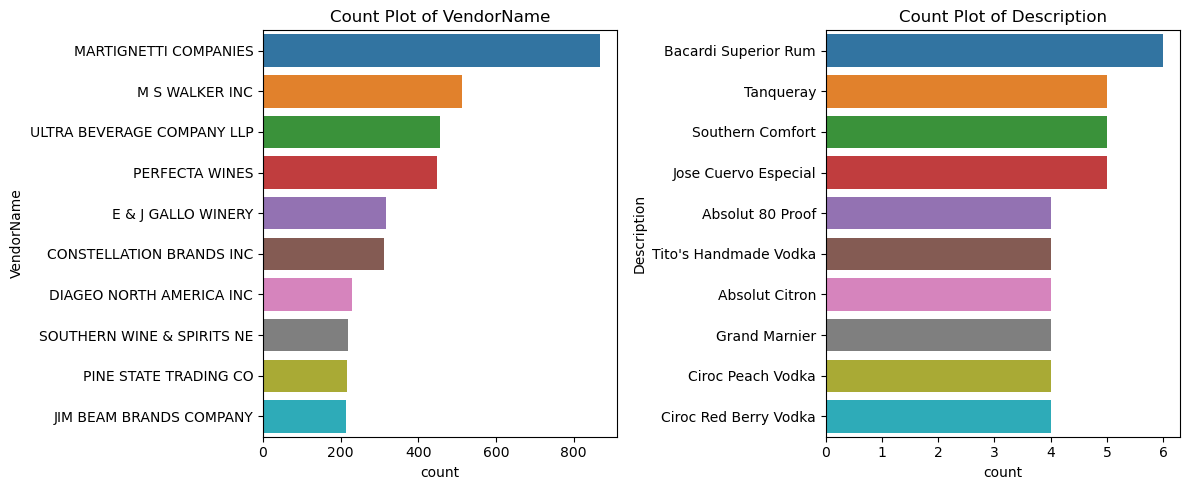

In [11]:
# Count Plots for Categorical Columns
categorical_cols = ["VendorName", "Description"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i + 1)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])  # Top 10 categories
    plt.title(f"Count Plot of {col}")

plt.tight_layout()
plt.show()


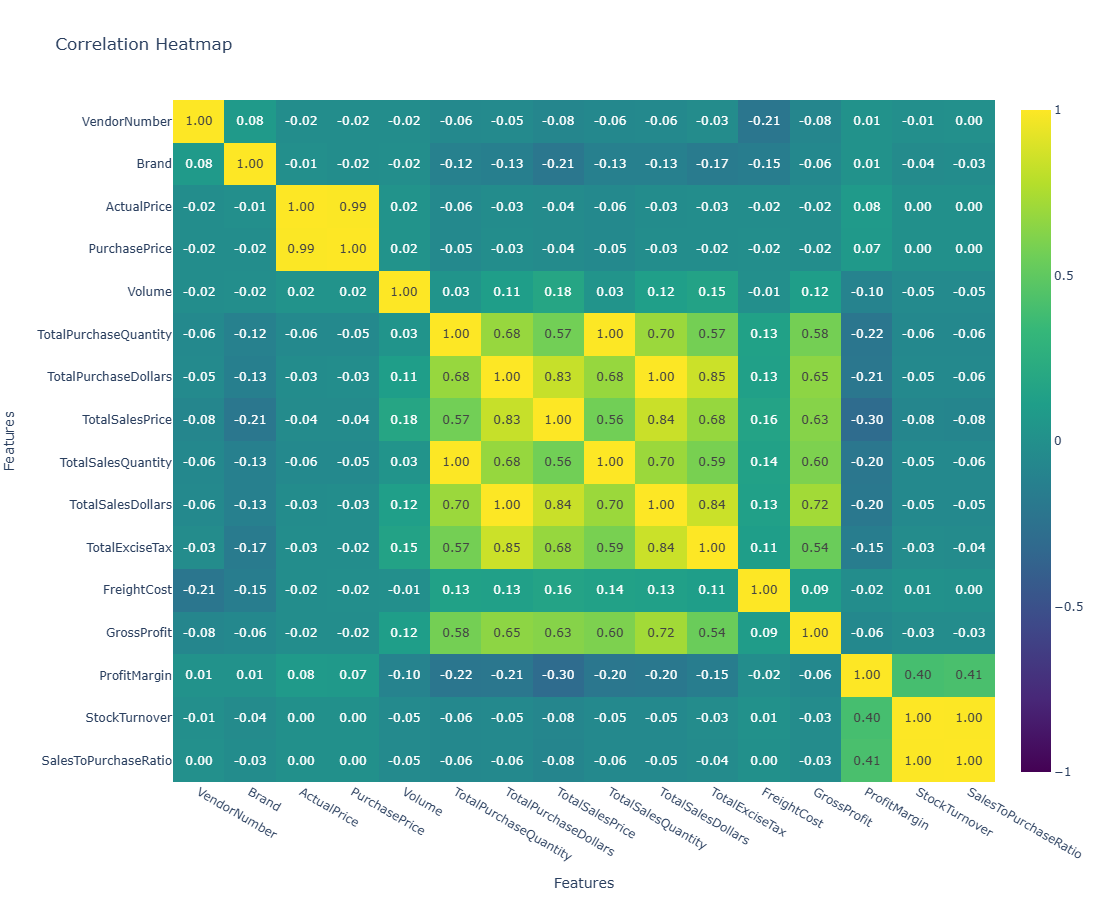

In [12]:
import plotly.express as px
import pandas as pd

# Compute correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Create the Plotly heatmap
fig = px.imshow(
    correlation_matrix,
    text_auto=".2f",  # 2 decimal places
    color_continuous_scale='Viridis',  
    zmin=-1, zmax=1,  # Fix scale from -1 to 1
    aspect="auto",
    title="Correlation Heatmap"
)

# Improve label layout
fig.update_layout(
    width=1000,
    height=900,
    xaxis_title="Features",
    yaxis_title="Features",
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

fig.show()


## Correlation Insights


* PurchasePrice shows a very strong positive correlation with ActualPrice (0.99), indicating they track closely — likely due to pricing being derived from base costs. However, it has negligible correlation with TotalSalesDollars (≈ -0.02) and GrossProfit (≈ -0.02), suggesting that variations in purchase price do not significantly influence overall revenue or profit.

* There is a very strong correlation between TotalPurchaseQuantity and TotalSalesQuantity (1.00), confirming tight alignment between procurement and sales, likely due to efficient inventory turnover or just-in-time purchasing strategies.

* ProfitMargin and TotalSalesPrice have a moderate negative correlation (~ -0.22), suggesting that as sales price increases, profit margins tend to drop, possibly reflecting discounting, volume deals, or pricing pressure in higher-value sales.

* StockTurnover shows moderate negative correlations with ProfitMargin (-0.40) and GrossProfit (-0.31), implying that faster turnover may be linked to leaner margins — possibly due to quick-moving, low-margin items driving most of the turnover.

* FreightCost has near-zero correlation with profitability metrics, indicating that freight expenses are not a direct driver of profit variation across the dataset.


---

# **Data Analysis**

#### **Identify Brands that need Promotional or Pricing Adjustments which exhibit lower Sales performance but higher Profit Margins**

In [13]:
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars': 'sum',
    'ProfitMargin': 'mean'
}).reset_index()

In [14]:
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

In [15]:
low_sales_threshold

552.5675

In [16]:
high_margin_threshold

70.83707563606167

In [17]:
#  filtering brands with low sales but high profit margins

targeted_brands = brand_performance[
                    (brand_performance['TotalSalesDollars'] <= low_sales_threshold) &
                    (brand_performance['ProfitMargin'] >= high_margin_threshold)
]
print('The Following are the brands with low sales but high profit margins')

display(targeted_brands.sort_values('TotalSalesDollars').reset_index())


The Following are the brands with low sales but high profit margins


index                   Description  TotalSalesDollars  ProfitMargin
0     1665   Concannon Glen Ellen Wh Zin              15.95     83.448276
1     1748             Crown Royal Apple              27.86     89.806174
2     4681  Sauza Sprklg Wild Berry Marg              27.96     82.153076
3     3630     Merry Irish Cream Liqueur              35.97     73.533500
4     5415                  Tracia Syrah              44.94     88.495772
..     ...                           ...                ...           ...
143   2815     Il Poggione di Montalcino             536.97     78.212936
144   1024       Casa Liliana Good Chard             538.51     94.986166
145   1807         Dad's Hat Rye Whiskey             538.89     81.851584
146   1696         Copain Wentzel Pnt Nr             539.91     85.475357
147   5697   Wolf Blass Yellow Lbl Chard             548.39     84.988785

[148 rows x 4 columns]

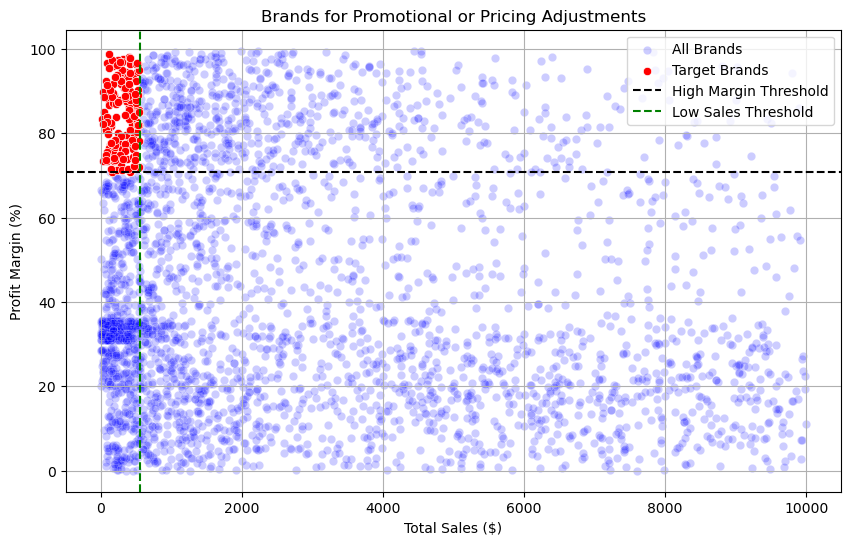

In [18]:
brand_performance = brand_performance[brand_performance['TotalSalesDollars'] < 10000]  # for better visualization

plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin', color="blue", label="All Brands", alpha=0.2)
sns.scatterplot(data=targeted_brands, x='TotalSalesDollars', y='ProfitMargin', color="red", label="Target Brands")

plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='green', label="Low Sales Threshold")

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()


#### **Which vendors and brands demonstrate the hihgest sales performance**

In [19]:
top_vendors = df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)

In [20]:
# Function to format dollar values
def format_dollars(value):
    if value >= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return str(value)


In [21]:
top_vendors.apply(lambda x: format_dollars(x))

VendorName
DIAGEO NORTH AMERICA INC      26.20M
MARTIGNETTI COMPANIES         22.76M
CONSTELLATION BRANDS INC      16.74M
BACARDI USA INC               15.12M
JIM BEAM BRANDS COMPANY       12.90M
E & J GALLO WINERY            11.60M
PERNOD RICARD USA             11.35M
M S WALKER INC                 9.64M
ULTRA BEVERAGE COMPANY LLP     9.52M
PROXIMO SPIRITS INC.           7.60M
Name: TotalSalesDollars, dtype: object

In [22]:
top_brands.apply(lambda x: format_dollars(x))

Description
Absolut 80 Proof                4.68M
Grey Goose Vodka                3.83M
Ketel One Vodka                 3.41M
Tanqueray                       2.73M
Bombay Sapphire Gin             2.08M
Jose Cuervo Especial            2.08M
Dewars White Label              1.91M
Tito's Handmade Vodka           1.89M
Bacardi Superior Rum            1.79M
Kendall Jackson Chard Vt RSV    1.76M
Name: TotalSalesDollars, dtype: object

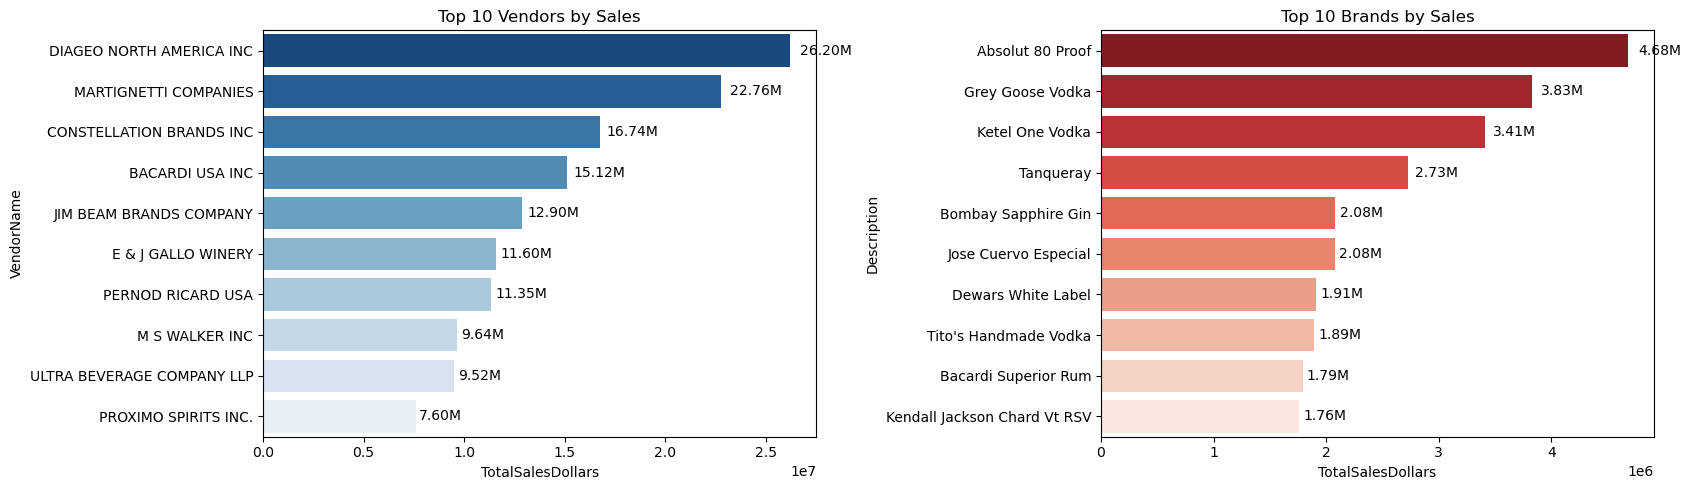

In [23]:
# Convert to DataFrames
top_vendors_df = top_vendors.reset_index()
top_brands_df = top_brands.reset_index()

plt.figure(figsize=(17, 5))

# --- Plot Top Vendors ---
plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=top_vendors_df, x='TotalSalesDollars', y='VendorName', palette="Blues_r")
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(
        bar.get_width() + bar.get_width() * 0.02,
        bar.get_y() + bar.get_height() / 2,
        format_dollars(bar.get_width()),
        ha='left', va='center', fontsize=10, color='black'
    )

# --- Plot Top Brands ---
plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=top_brands_df, x='TotalSalesDollars', y='Description', palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(
        bar.get_width() + bar.get_width() * 0.02,
        bar.get_y() + bar.get_height() / 2,
        format_dollars(bar.get_width()),
        ha='left', va='center', fontsize=10, color='black'
    )

plt.tight_layout()
plt.show()


#### **Which vendors contribute the most to total purchase dollars?**

In [32]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars': 'sum',
    'GrossProfit': 'sum',
    'TotalSalesDollars': 'sum'
}).reset_index()


In [34]:
vendor_performance['PurchaseContribution%'] = (vendor_performance['TotalPurchaseDollars']/vendor_performance['TotalPurchaseDollars'].sum()*100).round(0)

In [35]:
vendor_performance = round(vendor_performance.sort_values('PurchaseContribution%', ascending=False),2).reset_index()

In [36]:
# Display Top 10 Vendors
top_vendors = vendor_performance.head(10)

top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)

top_vendors


index                  VendorName TotalPurchaseDollars GrossProfit  \
0     24    DIAGEO NORTH AMERICA INC               23.74M       2.46M   
1     52       MARTIGNETTI COMPANIES               18.10M       4.66M   
2      5             BACARDI USA INC               13.46M       1.66M   
3     19    CONSTELLATION BRANDS INC               13.43M       3.32M   
4     42     JIM BEAM BRANDS COMPANY               11.58M       1.32M   
5     63           PERNOD RICARD USA               10.41M     943.57K   
6     28          E & J GALLO WINERY                9.63M       1.97M   
7     49              M S WALKER INC                7.95M       1.68M   
8     97  ULTRA BEVERAGE COMPANY LLP                7.53M       1.98M   
9     74              SAZERAC CO INC                5.86M     469.18K   

  TotalSalesDollars  PurchaseContribution%  
0            26.20M                   13.0  
1            22.76M                   10.0  
2            15.12M                    7.0  
3            16.74M                    7.0  
4            12.90M                    6.0  
5            11.35M                    5.0  
6            11.60M                    5.0  
7             9.64M                    4.0  
8             9.52M                    4.0  
9             6.33M                    3.0

In [37]:
top_vendors['Cumulative_Contribution%'] = top_vendors['PurchaseContribution%'].cumsum()

In [38]:
top_vendors

index                  VendorName TotalPurchaseDollars GrossProfit  \
0     24    DIAGEO NORTH AMERICA INC               23.74M       2.46M   
1     52       MARTIGNETTI COMPANIES               18.10M       4.66M   
2      5             BACARDI USA INC               13.46M       1.66M   
3     19    CONSTELLATION BRANDS INC               13.43M       3.32M   
4     42     JIM BEAM BRANDS COMPANY               11.58M       1.32M   
5     63           PERNOD RICARD USA               10.41M     943.57K   
6     28          E & J GALLO WINERY                9.63M       1.97M   
7     49              M S WALKER INC                7.95M       1.68M   
8     97  ULTRA BEVERAGE COMPANY LLP                7.53M       1.98M   
9     74              SAZERAC CO INC                5.86M     469.18K   

  TotalSalesDollars  PurchaseContribution%  Cumulative_Contribution%  
0            26.20M                   13.0                      13.0  
1            22.76M                   10.0                      23.0  
2            15.12M                    7.0                      30.0  
3            16.74M                    7.0                      37.0  
4            12.90M                    6.0                      43.0  
5            11.35M                    5.0                      48.0  
6            11.60M                    5.0                      53.0  
7             9.64M                    4.0                      57.0  
8             9.52M                    4.0                      61.0  
9             6.33M                    3.0                      64.0

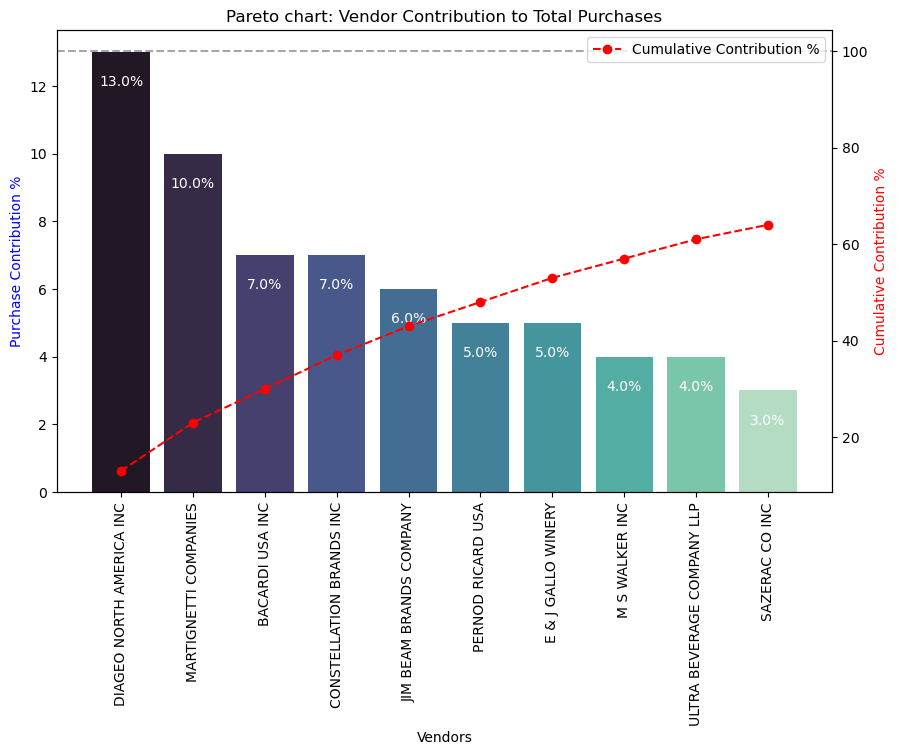

In [39]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Purchase Contribution%
sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchaseContribution%'], 
            palette="mako", ax=ax1)

for i, value in enumerate(top_vendors['PurchaseContribution%']):
    ax1.text(i, value - 1, str(value) + '%', ha='center', fontsize=10, color='white')

# Line Plot for Cumulative Contribution%
ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative_Contribution%'], 
         color='red', marker='o', linestyle='dashed', label='Cumulative Contribution %')

ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative Contribution %', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto chart: Vendor Contribution to Total Purchases')

ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.show()


### How much of the total Procurement is dependent on the top vendor?

In [40]:
# Calculate total purchase contribution of top 10 vendors
print(f"Total Purchase Contribution of top 10 vendors is {round(top_vendors['PurchaseContribution%'].sum(),2)} %")


Total Purchase Contribution of top 10 vendors is 64.0 %


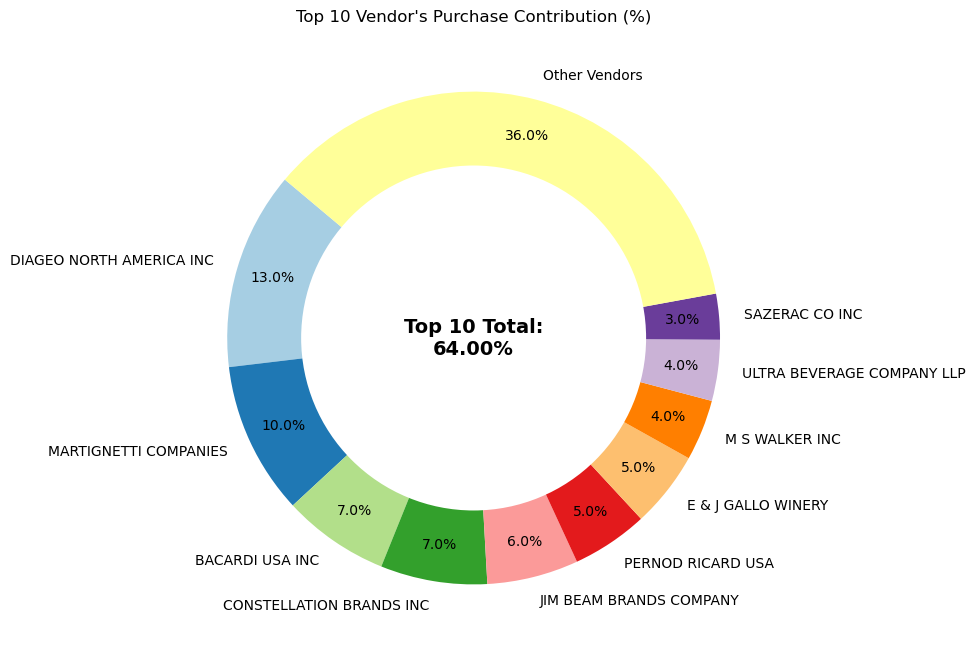

In [41]:
# Extract vendor names and purchase contributions
vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['PurchaseContribution%'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(purchase_contributions, labels=vendors, autopct='%1.1f%%',
                                 startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Draw a white circle in the center to create a "donut" effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add Total Contribution annotation in the center
plt.text(0, 0, f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()

### Does purchasing in bulk reduce the unit price, if so what is the optimal purchase volume for cost savings?

In [44]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars']/df['TotalPurchaseQuantity']

In [45]:
df.head()

VendorNumber                VendorName  Brand         Description  \
0         17035         PERNOD RICARD USA   8068    Absolut 80 Proof   
1          3960  DIAGEO NORTH AMERICA INC   3545     Ketel One Vodka   
2           480           BACARDI USA INC   3858    Grey Goose Vodka   
3          3960  DIAGEO NORTH AMERICA INC   3489           Tanqueray   
4           480           BACARDI USA INC   2663  Dewars White Label   

   ActualPrice  PurchasePrice  Volume  TotalPurchaseQuantity  \
0        24.99          18.24  1750.0                 187407   
1        29.99          21.89  1750.0                 138109   
2        23.99          17.77   750.0                 138809   
3        27.99          20.73  1750.0                  91835   
4        29.99          21.42  1750.0                  69001   

   TotalPurchaseDollars  TotalSalesPrice  TotalSalesQuantity  \
0            3418303.68        365628.68            145074.0   
1            3023206.01        428454.74             99417.0   
2            2466635.93        352917.21            106580.0   
3            1903739.55        399771.60             71399.0   
4            1478001.42        390902.86             50325.0   

   TotalSalesDollars  TotalExciseTax  FreightCost  GrossProfit  ProfitMargin  \
0         3535864.76       266561.29    123780.22    117561.08      3.324818   
1         3117155.83       182667.44    257032.07     93949.82      3.013960   
2         2548893.20        83919.92     89286.27     82257.27      3.227176   
3         2099802.01       131184.43    257032.07    196062.46      9.337188   
4         1595656.75        92464.93     89286.27    117655.33      7.373474   

   StockTurnover  SalesToPurchaseRatio  UnitPurchasePrice  
0       0.774112              1.034392              18.24  
1       0.719844              1.031076              21.89  
2       0.767818              1.033348              17.77  
3       0.777470              1.102988              20.73  
4       0.729337              1.079604              21.42

In [46]:
df['OrderSize'] = pd.qcut(df['TotalPurchaseQuantity'],q=3,labels = ['small','medium','large'])

In [48]:
df[['OrderSize','TotalPurchaseQuantity']]

OrderSize  TotalPurchaseQuantity
0        large                 187407
1        large                 138109
2        large                 138809
3        large                  91835
4        large                  69001
...        ...                    ...
6280     small                      2
6281     small                      2
6282     small                      6
6283     small                      1
6284     small                      1

[6285 rows x 2 columns]

In [51]:
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

UnitPurchasePrice
OrderSize                   
small              43.866038
medium             13.419862
large               9.167771

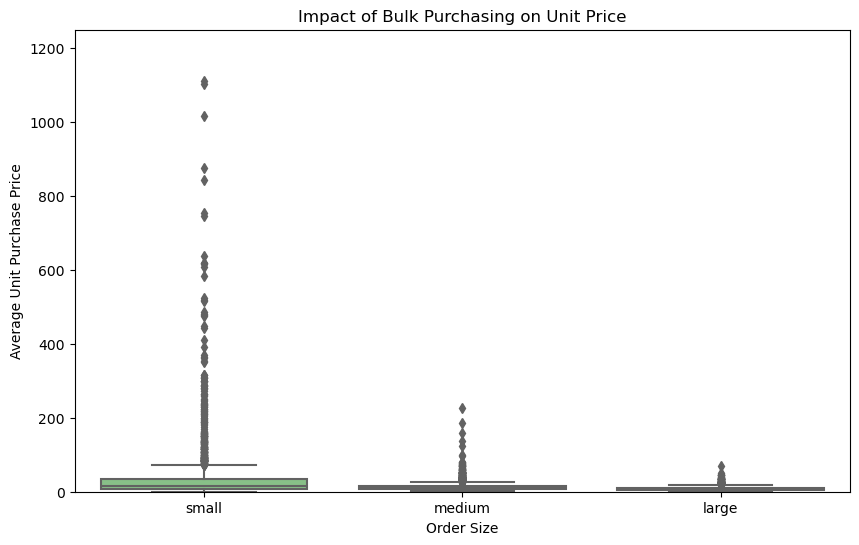

In [55]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Accent")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.ylim(0, 1250)
plt.show()

• Vendors buying in bulk (Large OrderSize) get the lowest unit price ($9.16 per unit), meaning higher margins if they can manage inventory efficiently.

• The price difference between Small and Large orders is substantial (~72% reduction in unit cost)

• This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volumes, leading to higher overall sales despite lower per-unit revenue.

---

### Which vendors have low inventory turnover, indicating excess stock and slow-moving products?

In [59]:
df[df['StockTurnover'] < 1].groupby('VendorName')[['StockTurnover']].mean().sort_values('StockTurnover', ascending = True).head(10)

StockTurnover
VendorName                            
ALISA CARR BEVERAGES          0.500000
WEIN BAUER INC                0.666667
Dunn Wine Brokers             0.666667
INCREDIBREW INC               0.669244
JEWELL TOWNE VINEYARDS        0.679410
CANDIA VINEYARDS              0.680930
LABELLE VYDS AND WINERY       0.680963
SWEET BABY VINEYARD           0.682777
THE IMPORTED GRAPE LLC        0.690436
ZORVINO VINEYARDS             0.697553

### How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?

In [60]:
# Calculate unsold inventory value
df["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]
print('Total Unsold Capital:', format_dollars(df["UnsoldInventoryValue"].sum()))

Total Unsold Capital: 39.27M


In [61]:
# Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby("VendorName")["UnsoldInventoryValue"].sum().reset_index()

# Sort Vendors with the Highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue", ascending=False)
inventory_value_per_vendor["UnsoldInventoryValue"] = inventory_value_per_vendor["UnsoldInventoryValue"].apply(format_dollars)
inventory_value_per_vendor.head(10)

VendorName UnsoldInventoryValue
24  DIAGEO NORTH AMERICA INC                4.90M
52     MARTIGNETTI COMPANIES                3.71M
19  CONSTELLATION BRANDS INC                3.13M
5            BACARDI USA INC                2.72M
28        E & J GALLO WINERY                2.33M
42   JIM BEAM BRANDS COMPANY                2.31M
63         PERNOD RICARD USA                2.28M
49            M S WALKER INC                1.61M
74            SAZERAC CO INC                1.37M
69      PROXIMO SPIRITS INC.                1.19M

### What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors.

In [62]:

# Define thresholds for top and low performing vendors
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

# Filter vendors based on performance
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

In [63]:
top_vendors

0        3.324818
1        3.013960
2        3.227176
3        9.337188
4        7.373474
          ...    
2753    78.216995
2994    85.506797
3394    92.448459
3532    94.866911
3621    93.846272
Name: ProfitMargin, Length: 1572, dtype: float64

In [64]:
low_vendors

4039     0.030697
4075     6.106422
4076     1.248186
4079     6.535337
4086     3.967281
          ...    
6280    89.806174
6281    83.448276
6282    96.436186
6283    98.704047
6284    99.166079
Name: ProfitMargin, Length: 1572, dtype: float64

In [65]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))  # Standard error
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (16.13, 17.47), Mean: 16.80
Low Vendors 95% CI: (43.33, 46.04), Mean: 44.69


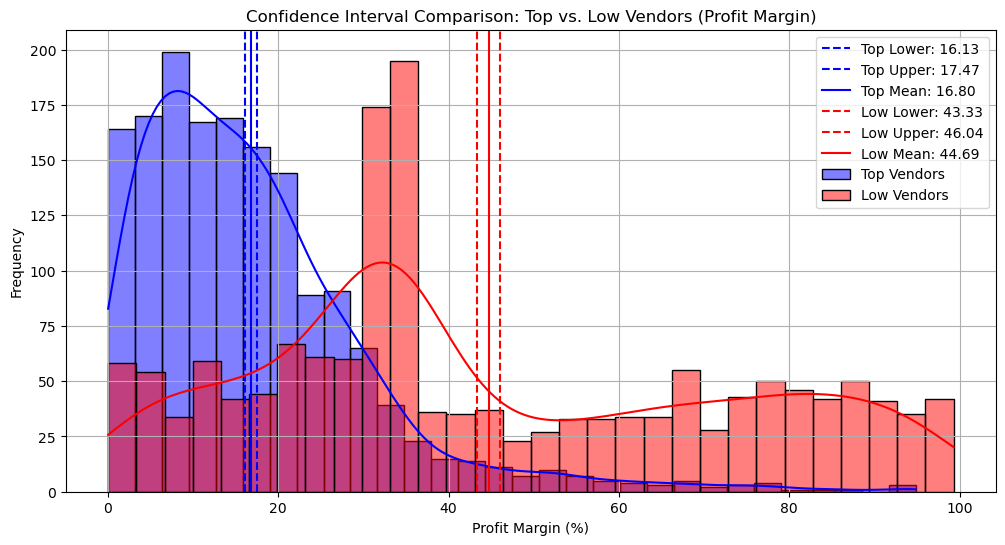

In [66]:
# Calculate confidence intervals for top and low vendors
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

# Print confidence interval results
print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

# Create figure with subplots
plt.figure(figsize=(12, 6))

# Top Vendors Plot
sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot
sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

### Key Findings:

- Low-performing vendors have higher profit margins (43.33% to 46.04%)
- Top-performing vendors have lower profit margins (16.13% to 17.47%)
- This is the opposite of what you might expect!

- Low-performing vendors likely use premium pricing strategies or have lower operational costs
High-performing vendors might sacrifice margin for volume (competitive pricing to drive sales)

#### Strategic Implications:
##### For High-Performing Vendors:

**They're already successful with lower margins (high volume strategy)
Could potentially increase profitability through:**

- Selective price adjustments on popular items
- Cost optimization to improve margins without raising prices
- Product bundling to increase average transaction value


##### For Low-Performing Vendors:

**High margins but low sales suggest pricing or marketing issues
Need to focus on:**

- Better marketing to increase visibility
- Competitive pricing to attract more customers
- Improved distribution to reach more buyers

---

### Hypothesis Testing:

**Research Question:**
Is there a significant difference in profit margins between top-performing and low-performing vendors?
The Two Hypotheses:
- H₀ (Null Hypothesis):

"There is no significant difference in the mean profit margins of top-performing and low-performing vendors".
This assumes any observed difference is just due to random chance.
We start by assuming this is true until proven otherwise.

- H₁ (Alternative Hypothesis):

"The mean profit margins of top-performing and low-performing vendors are significantly different".
This is what we're trying to prove.
It suggests there's a real, meaningful difference.

In [68]:

# Define thresholds for top and low performing vendors
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

# Filter vendors based on performance
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

# perform 2-sample t-test:

t_stat, p_value = ttest_ind(top_vendors,low_vendors,equal_var=False)

#Print results

print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to Reject H₀: No significant difference in profit margins.")


T-Statistic: -36.1514, P-Value: 0.0000
Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.
